## Project Overview
- Covid 19 has med the Stock market very volatime in the last few months. 
- You have been assigned to attempt to forecast the value of the S&P one day forward into the future

## Poject Approach
- Create a model that will train on data from the begining of 2020 until current data
- This will capture the behavior during Covid 19
- Back test this model 2 months back to test accuracy
- Create predictions for a certain period to test the precision of the model before forecasting

### Data Fetching 
- Will download data from Yahoo Finance API via Pandas 

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pandas_datareader import data as web

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
data = pd.DataFrame(web.DataReader("^GSPC", data_source = "yahoo", start = "2020-1-1")["Adj Close"])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94 entries, 2020-01-02 to 2020-05-15
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  94 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB


## initial Analysis 
- The effects of COVID on the market can be seen mostly at the Beginning of March 
- The market took a steady climb back from Early april to current where we see some sign of "normal"bahavior
- Volatility in the market shows more of an increase since April 1 2020

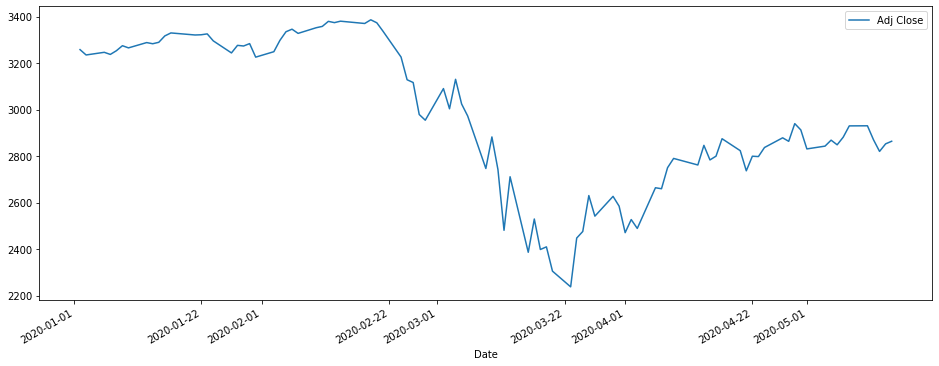

In [5]:
data.plot(figsize = (16,6)) 

## Preparing our data
- What the approach should be here is to take a good amount of data out of this set to train on and validate again a teting set.
- Because of the high volatility in the data we should expect a lower accuracy in predictions. A good way of overriding this issue is maybe to gather a larger time frame of data
- Becaue we have approximately 3+ months (trading days) of data we will test on 30 days and train on 2 months approximately. THis is not a larget sum of data but could give us some insight on the movement of the market

In [6]:
testing_sample = 30

In [7]:
testing_index = len(data) - testing_sample

In [8]:
train = data.iloc[:testing_index]

In [9]:
test = data.iloc[testing_index:]

In [10]:
train.shape

(64, 1)

In [11]:
test.shape

(30, 1)

### Scaling the data
- Will scale to consider the full range in the standard deviation of the data 
- Model will be abel to consider all outliers in training

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scalar = MinMaxScaler()

In [14]:
train_scaled = scalar.fit_transform(train)

In [15]:
test_scaled = scalar.transform(test)

In [16]:
train_scaled.shape

(64, 1)

In [17]:
test_scaled.shape

(30, 1)

## Time Series Generator
- Will use a generator to train our data using a specified length of time to attempt to predict
- Since we are only aiming to predict one feature we will use a feature count of 1
- Length to attempt to predict will be 5 trading days though we are aiming for 1 day our
- The first prediciton on the LSTM model is more accurate do to gradient decay

In [18]:
length =5
n_features = 1

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
gen = TimeseriesGenerator(train_scaled,train_scaled, length = length, batch_size=1)

## Validation Data
- Will use to put our training data up again to improve training

In [21]:
vali_gen = TimeseriesGenerator(test_scaled,test_scaled, length=length, batch_size=1)

### Early Stopping
- Will use to prevent Over Training of the model

In [22]:
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

In [23]:
stop = EarlyStopping(monitor="val_loss", mode = "max", patience= 60)

### Model Creation 
- We will use a LSTM model for improvement in predictions. LSTM is a better training model since it will take into account Gradient Decay

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [25]:
model = Sequential()
model.add(LSTM(units=400, activation = "relu", input_shape = (length,n_features)))
model.add(Dense(units = 1))
model.compile(loss = "mse", optimizer = "adam")

### Fittiing Model 
- Will fit model to the generator , validation data, a high epoch, and use early stopping to precvent over training

In [26]:
model.fit_generator(generator=gen, validation_data=vali_gen, epochs=100, callbacks=[stop])

Epoch 1/100
59/59 [==============================] - 2s 30ms/step - loss: 0.0735 - val_loss: 0.0078
Epoch 2/100
59/59 [==============================] - 2s 30ms/step - loss: 0.0149 - val_loss: 0.0040
Epoch 3/100
59/59 [==============================] - 2s 30ms/step - loss: 0.0175 - val_loss: 0.0061
Epoch 4/100
59/59 [==============================] - 2s 30ms/step - loss: 0.0174 - val_loss: 0.0030
Epoch 5/100
59/59 [==============================] - 2s 30ms/step - loss: 0.0144 - val_loss: 0.0034
Epoch 6/100
59/59 [==============================] - 2s 29ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 7/100
59/59 [==============================] - 2s 29ms/step - loss: 0.0126 - val_loss: 0.0035
Epoch 8/100
59/59 [==============================] - 2s 30ms/step - loss: 0.0108 - val_loss: 0.0094
Epoch 9/100
59/59 [==============================] - 2s 30ms/step - loss: 0.0121 - val_loss: 0.0216
Epoch 10/100
59/59 [==============================] - 2s 29ms/step - loss: 0.0105 - val_loss: 0.0074

### Model Performance
- Lets see the results of the model training
- looks like our model performed very well 
- We will take a look at theprodictions below 
- We will save this model for future Predictions

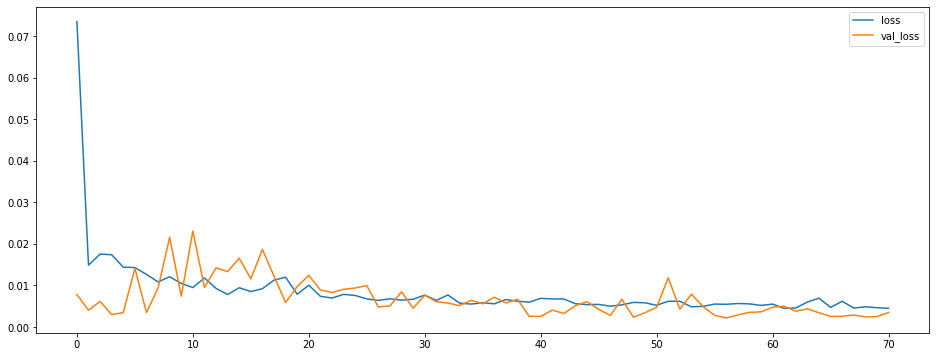

In [27]:
pd.DataFrame(model.history.history).plot(figsize = (16,6))

In [61]:
#model.save("sandpModel.h5")

In [29]:
model_his = pd.DataFrame(model.history.history)

In [62]:
#model_his.to_csv("model_history.csv")

### Model Predictions
- We will predict the test values range from our test data set 
- This will tell us how accurate our model is on a first day prediciton before forecasting

In [31]:
test_predicitons = []
batch = train_scaled[-length:]
current_batch = batch.reshape((1,length,n_features))
for i in range(len(test)):
    prediction = model.predict(current_batch)[0]
    test_predicitons.append(prediction)
    current_batch = np.append(current_batch[:,1:,:], [[prediction]], axis =1)

## inverse Scaling
- The data was trained on scaled data so to get the true values of the predicitons we need to inverse the scaling
- we will match the predictions data with our test data to check performance

In [32]:
true_predictions = scalar.inverse_transform(test_predicitons)

In [33]:
test["predicitons"] = true_predictions

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


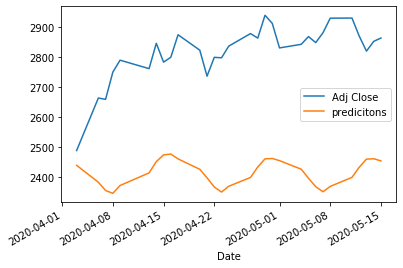

In [34]:
test.plot()

## Model Accuracy
- Model predicted the Value of S&P to bte 2496.5 adn the true value on 2020-4-3 was 2488.6.. This was pretty accurate,
- We can now try to forecast on this model

In [35]:
test.head(1)

,Adj Close,predicitons
Date,,
2020-04-03,2488.649902,2439.49926


## Forecasting
- We will forecast 5 daty ahead of out data set using the data we cllected for the covid time frame
- We Must first scale our data before forecasting

In [36]:
data_scalar = MinMaxScaler()

In [37]:
data_scaled = data_scalar.fit_transform(data)

In [38]:
data_scaled.shape

(94, 1)

In [39]:
forecast = []
periods = length
bb = data_scaled[-length:]
curr_b = bb.reshape(1,length,n_features)
for l in range(periods):
    predict = model.predict(curr_b)[0]
    forecast.append(predict)
    curr_b = np.append(curr_b[:,1:,:], [[predict]], axis = 1)

### Inverse forecast
- We will need to inverse the scaled data to get the true forecast

In [40]:
true_Forecast = data_scalar.inverse_transform(forecast)

In [41]:
true_Forecast

array([[2809.20662977],
       [2812.2405725 ],
       [2778.71663511],
       [2754.59651653],
       [2730.6196047 ]])

### Time Series
- We need a time series for our 5 day forecast
- We will begin one day ahead of the end of our data series seen below

In [42]:
data.tail().iloc[-1:].reset_index().iloc[0]["Date"]

Timestamp('2020-05-15 00:00:00')

In [43]:
forecast_period = pd.date_range(start = "2020-05-16", periods=periods, freq="B")

In [44]:
forecast_df = pd.DataFrame(true_Forecast,index=forecast_period, columns=["Forecast"])

## Forecast Consideration
- We will only consider the forecast for the first day forward in our case 2020-5-18

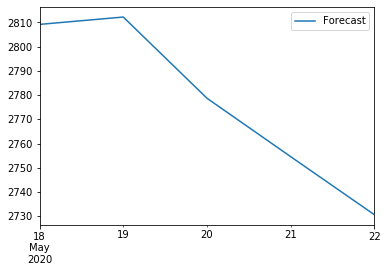

In [45]:
forecast_df.plot()

## plot with data

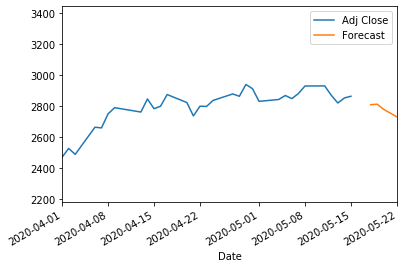

In [46]:
ax = data.plot()
forecast_df.plot(ax = ax)
plt.xlim("2020-4-1", "2020-5-22");

In [47]:
forecast_df.head(1)

,Forecast
2020-05-18,2809.20663


In [48]:
data.tail().iloc[-1:]

,Adj Close
Date,
2020-05-15,2863.699951


### Summary Of model Predictions
- Model predicts the ADJ close for the market for 5-18-2020 will be 2794.72
- Where are the previsous day was 2863.69

#### Back Test
- Lets take out model back a bit to see how it will forecast
- This will give us a sense of if our forecast above has a chance of being accurate
- We will take a few weeks/days off the data set 

### Forecasting on backtest
- We will aim to forecast on the the day after 2020-5-4 with our model

In [49]:
back_test = data.loc["2020-1-2":"2020-5-4"]

In [50]:
back_test

,Adj Close
Date,
2020-01-02,3257.850098
2020-01-03,3234.850098
2020-01-06,3246.280029
2020-01-07,3237.179932
2020-01-08,3253.050049
...,...
2020-04-28,2863.389893
2020-04-29,2939.510010
2020-04-30,2912.429932


In [51]:
back_test_Scalar = MinMaxScaler()

In [52]:
back_test_scaled = back_test_Scalar.fit_transform(back_test)

In [53]:
backtest_forecast = []
perio = length
b = back_test_scaled[-length:]
bb_curr = b.reshape(1,length,n_features)
for i in range(perio):
    pre = model.predict(bb_curr)[0]
    backtest_forecast.append(pre)
    bb_curr = np.append(bb_curr[:,1:,:], [[pre]], axis=1)

In [54]:
true_back_forecast = back_test_Scalar.inverse_transform(backtest_forecast)

In [55]:
true_back_forecast

array([[2802.4893669 ],
       [2767.78002817],
       [2751.9173212 ],
       [2718.48780509],
       [2682.62117229]])

## Back Forecast TIme series

In [56]:
forecast_date_time = pd.date_range(start = "2020-05-5", periods=perio, freq="B")

In [57]:
back_df = pd.DataFrame(true_back_forecast, index=forecast_date_time, columns=["Forecast"])

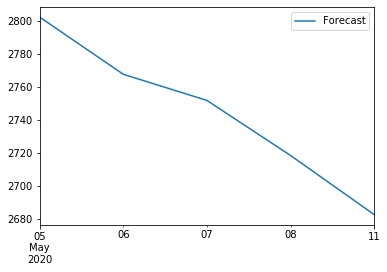

In [58]:
back_df.plot()

### Model Prediction

In [59]:
back_df.head(1)

,Forecast
2020-05-05,2802.489367


## True value on that Date

In [60]:
data.loc["2020-5-5"]

Adj Close    2868.439941
Name: 2020-05-05 00:00:00, dtype: float64